In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import yaml
import json
import os
import sys
sys.path.append('../')
sys.path.append('../external/hovernet')
sys.path.append('../deconvplugin')

PATH = '/home/luca/Documents/data/'
# '/cluster/CBIO/data1/lgortana/'
# '/home/luca/Documents/data_CBIO/'
# '/home/luca/Documents/data/'

# Ground truth

In [2]:
import torch

#load adata
adata_name = 'Xenium_FFPE_Human_Breast_Cancer_Rep1'
data_path = os.path.join(PATH, adata_name)
path_ST_adata = os.path.join(data_path, f'sim_hn/pseudo_adata_real.h5ad')
adata = sc.read_h5ad(path_ST_adata) #read_visium or read_h5ad

#image path
image_path = os.path.join(data_path, 'pyr_tif/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif')
image_dict = torch.load(os.path.join(data_path, "image_dict_64.pt"))

#load image infos
gt_json_path = os.path.join(data_path, f'sim_hn/pannuke_fast_mask_lvl3_annotated.json')
with open(gt_json_path) as json_file:
    gt_seg_dict = json.load(json_file)

In [3]:
import pandas as pd

#load spot proportions
spot_prop_df = pd.read_csv(os.path.join(data_path, f'sim_hn/sim_Xenium_FFPE_Human_Breast_Cancer_Rep1_prop_real.csv'), index_col=0)
spot_prop_df.index = spot_prop_df.index.astype(str)
ct_list = list(spot_prop_df.columns)

#load spot dict
with open(os.path.join(data_path, f'sim_hn/spot_dict_real.json'), "r") as file:
    spot_dict = json.load(file)

#load cell predictions
gt = pd.read_csv(os.path.join(data_path, f'sim_hn/sim_Xenium_FFPE_Human_Breast_Cancer_Rep1_gt.csv'), index_col=0)
gt.index = gt.index.astype(str)

In [4]:
from deconvplugin.basics import generate_color_dict
dict_types_colors = generate_color_dict(ct_list, format='special')
dict_types_colors[f'{len(ct_list)}'] = ['Unlabeled', [0, 0, 0, 255]]
dict_types_colors[f'{len(ct_list)+1}'] = ['no_match', [170, 170, 170, 255]]

In [6]:
from deconvplugin.analysis.postseg import count_cell_types
count_cell_types(gt_seg_dict, [item[0] for item in list(dict_types_colors.values())])

no_match  neopla  connec  Unlabeled  inflam
0     48070   48365   45147       6438   27184

In [7]:
from deconvplugin.analysis.postseg import StdVisualizer

plotter_gt = StdVisualizer(image_path=image_path,
                        adata=adata,
                        adata_name=adata_name,
                        seg_dict=gt_seg_dict,
                        color_dict=dict_types_colors)

Visium data found.


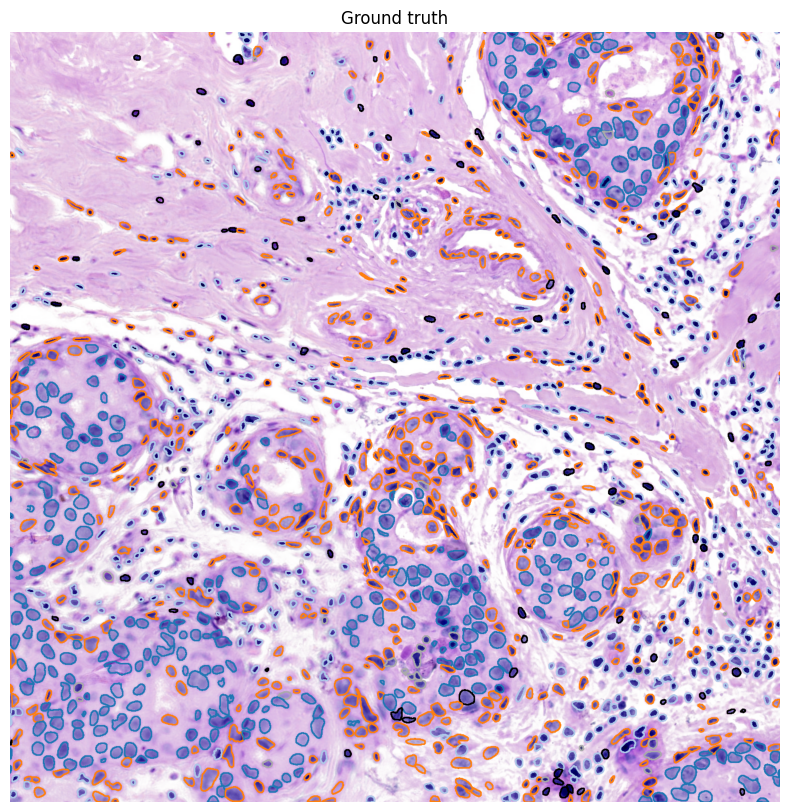

In [8]:
window = ((17000, 17000), (1500, 1500))
plotter_gt.plot_seg(window=window, show_visium=False, title='Ground truth', display=True, figsize=(10, 10))
# fig.savefig(f"../results/HoVerNet/{adata_name}/crop_3types_gt_17000_17000_1500.png", dpi=300, bbox_inches='tight')

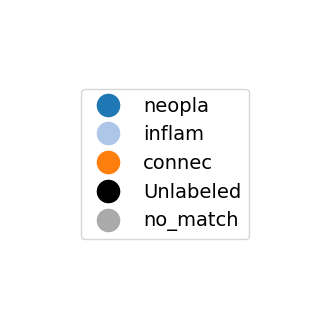

In [9]:
from deconvplugin.analysis.plots import plot_legend

plot_legend(dict_types_colors)

# Deconv-plugin predictions

In [11]:
import pickle

#load model infos
model_tag = 'model_quick_alpha_0.0_lr_0.0003_weights_False_divergence_l2_beta_1.0_seed_8'
model_dir = os.path.join(f'results/HoVerNet/{adata_name}/deconv-plugin', model_tag)

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

In [12]:
from deconvplugin.analysis.pred_analyzer import PredAnalyzer

analyzer_dp = PredAnalyzer(model_info=model_info,
                        adjusted=True,
                        ground_truth=gt, 
                        image_dict=image_dict
                        )

Loading predicted labels...
Loading true labels...
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


In [13]:
pd.DataFrame(analyzer_dp.proportions.mean(axis=0)).T

neopla    inflam    connec
0  0.334304  0.197461  0.468234

In [14]:
analyzer_dp.add_attributes(adata=adata,
                        adata_name=adata_name,
                        image_path=image_path,
                        seg_dict=gt_seg_dict)

In [15]:
from deconvplugin.analysis.postseg import StdVisualizer

plotter_dp = StdVisualizer(image_path, 
                        adata, 
                        adata_name, 
                        seg_dict=analyzer_dp.seg_dict_w_class,
                        color_dict=analyzer_dp.color_dict)

Visium data found.


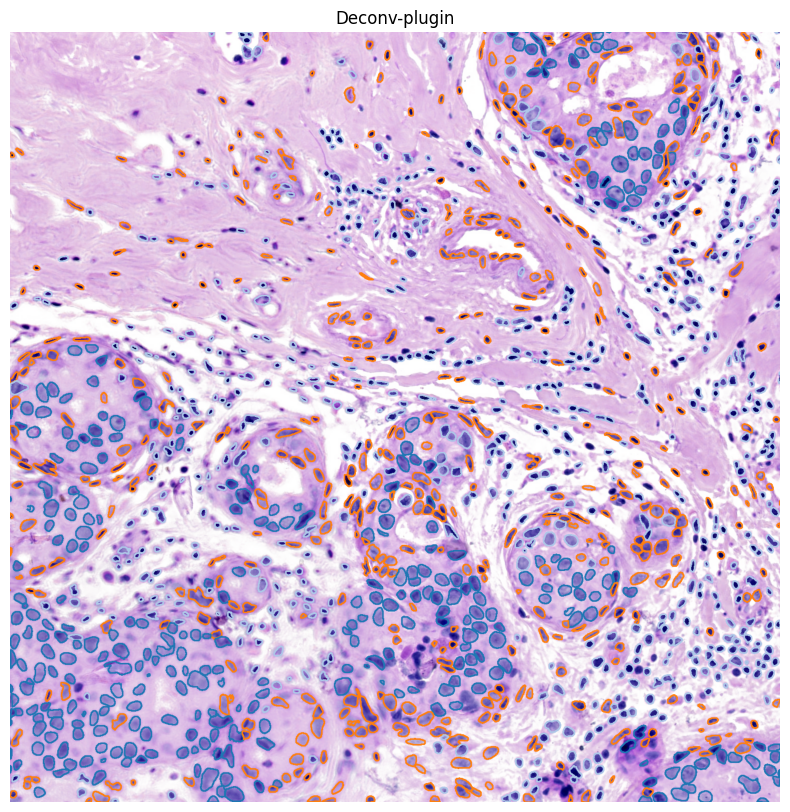

In [16]:
window = ((17000, 17000), (1500, 1500)) #((4500, 14500), (2000, 2000))
plotter_dp.plot_seg(window=window, show_visium=False, title='Deconv-plugin', display=True, figsize=(10, 10))
# fig.savefig(f"../results/HoVerNet/{adata_name}/crop_3types_deconvplugin_17000_17000_1500.png", dpi=300, bbox_inches='tight')

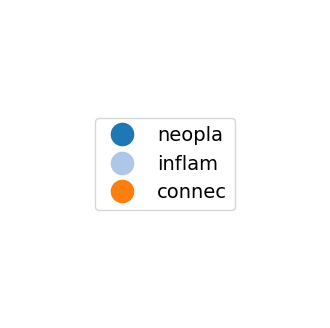

In [17]:
plot_legend(analyzer_dp.color_dict)

# HoVerNet pre-classification

In [18]:
#load original hovernet segmentation
hovernet_json_path = os.path.join(data_path, f'seg_json/pannuke_fast_mask_lvl3.json')
with open(hovernet_json_path) as json_file:
    hovernet_seg_dict = {'mag': None,
                         'nuc': {str(i): v for i, (k, v) in enumerate(json.load(json_file)['nuc'].items())}}
    
dict_types_path = "../references/colors_hovernet.yaml"
with open(dict_types_path, 'r') as file:
    dict_types = yaml.load(file, Loader=yaml.FullLoader)["pannuke"]

In [19]:
cell_types = {int(k): v[0] for k, v in dict_types.items()}

rows = []
for cell_id, cell_info in hovernet_seg_dict['nuc'].items():
    type_id = cell_info['type']
    row = {cell_type: 0 for cell_type in cell_types.values()}
    row[cell_types[type_id]] = 1
    row['nucleus_id'] = cell_id
    rows.append(row)

hn_preds = pd.DataFrame(rows).set_index('nucleus_id')

In [20]:
#remove necros and no-neo cells from the predictions
hn_preds = hn_preds[(hn_preds['necros'] == 0) & (hn_preds['no-neo'] == 0) & (hn_preds['nolabe'] == 0)]
hn_preds = hn_preds.drop(columns=['necros', 'no-neo', 'nolabe'])

In [21]:
#keep intersection of indices
common_indices = gt.index.intersection(hn_preds.index)
filtered_gt = gt.loc[common_indices]
filtered_hn_preds = hn_preds.loc[common_indices]

In [57]:
# common_indices.to_series().to_csv(os.path.join(data_path, 'sim_hn', 'remaining_cells_hn.csv'), index=False)

In [22]:
from deconvplugin.analysis.pred_analyzer import PredAnalyzer

preds = {'pred_best': filtered_hn_preds}

analyzer = PredAnalyzer(preds=preds,
                        spot_dict=spot_dict,
                        adjusted=False,
                        ground_truth=filtered_gt, 
                        image_dict=image_dict
                        )

Loading predicted labels...
Loading true labels...
Use `add_attributes(history=your_history)` to add one.
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


In [23]:
analyzer.add_attributes(adata=adata,
                        adata_name=adata_name,
                        image_path=image_path,
                        seg_dict=hovernet_seg_dict)

In [24]:
from deconvplugin.analysis.postseg import StdVisualizer

plotter_hn = StdVisualizer(image_path, 
                        adata, 
                        adata_name, 
                        seg_dict=analyzer.seg_dict_w_class,
                        color_dict=analyzer.color_dict)

Visium data found.


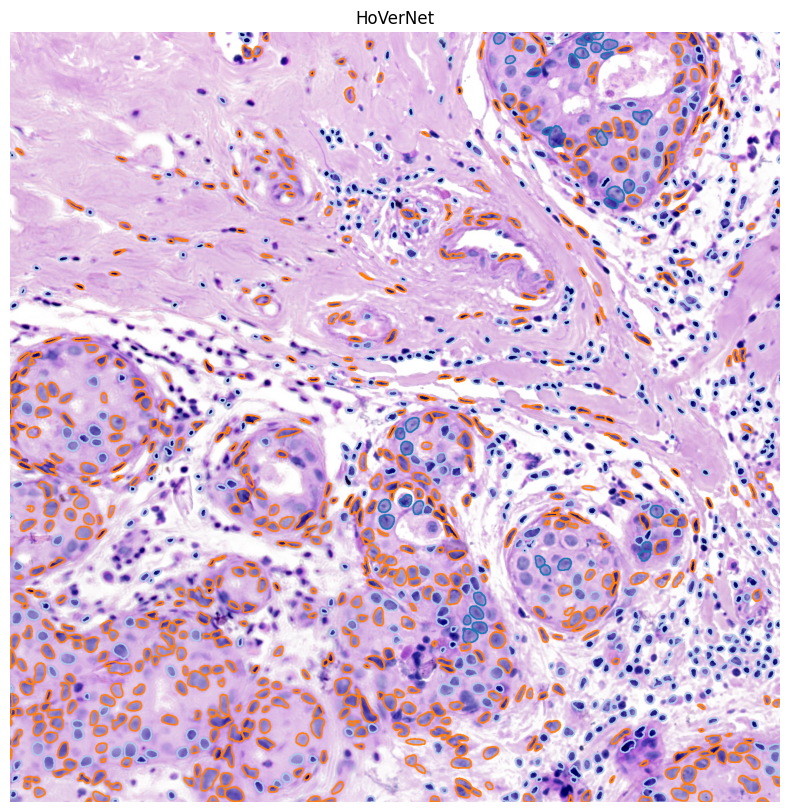

In [25]:
window = ((17000, 17000), (1500, 1500)) #((3000, 20000), (2000, 2000))
plotter_hn.plot_seg(window=window, show_visium=False, title='HoVerNet', display=True, figsize=(10, 10))
# fig.savefig(f"../results/HoVerNet/{adata_name}/crop_3types_hn_17000_17000_1500.png", dpi=300, bbox_inches='tight')

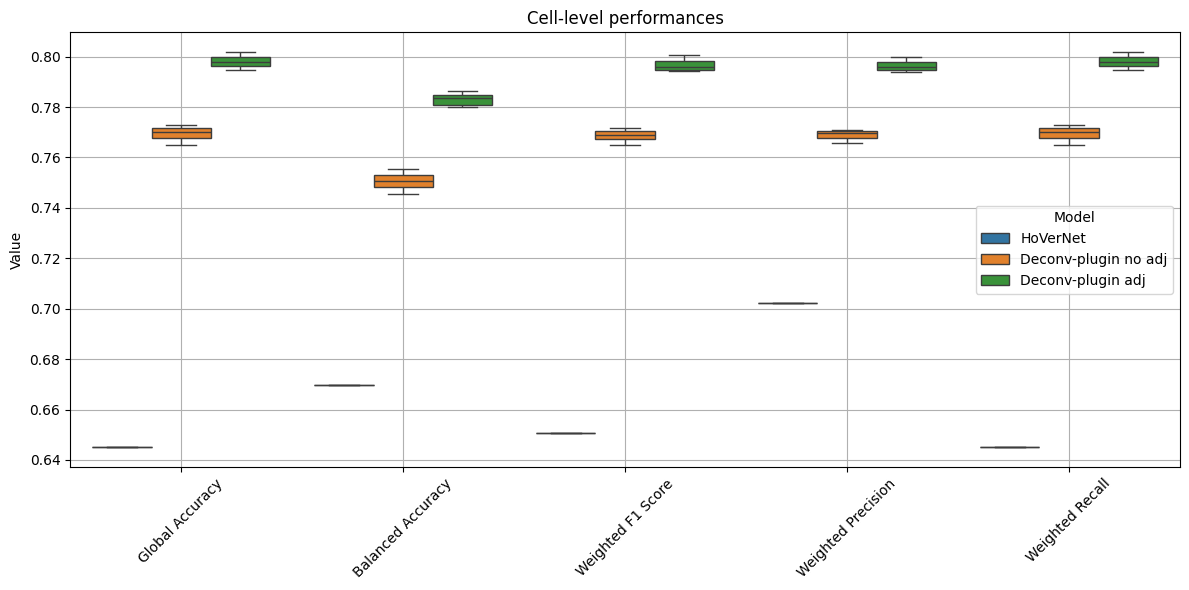

In [ ]:
from utils import box_plot_perf

file_hovernet = "results/HoVerNet/Xenium_FFPE_Human_Breast_Cancer_Rep1/metrics.xlsx"
file_deconvplugin_no_adj = "results/HoVerNet/Xenium_FFPE_Human_Breast_Cancer_Rep1/deconv-plugin/metrics_cells_best.xlsx"
file_deconvplugin = "results/HoVerNet/Xenium_FFPE_Human_Breast_Cancer_Rep1/deconv-plugin/metrics_cells_best_adj.xlsx"

files_info = [
    (file_hovernet, 'per_run', 'HoVerNet'),
    (file_deconvplugin_no_adj, 'per_run', 'Deconv-plugin (no adj)'),
    (file_deconvplugin, 'per_run', 'Deconv-plugin')
]

box_plot_perf(files_info, level='cells', title='Cell-level performances')